<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course


Author: Vitaly Radchenko. All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Assignment # 5 (demo)</center>
## <center>Logistic Regression and Random Forest in the credit scoring problem</center> 

**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol).**

In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer the questions in the [form](https://docs.google.com/forms/d/1gKt0DA4So8ohKAHZNCk58ezvg7K_tik26d9QND7WC6M/edit).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

1. 70.00%
2. 83.20%
3. 83.70%
4. 87.50%

The following formula was given to calculate the probability of the decidion, based on each of the jurors individual probability:

$$ \large \mu = \sum_{i=m}^{N}{N\choose i}p^i(1-p)^{N-i} $$


In [1]:
#So, this formula can be formalized as a function

from math import floor
from math import factorial

def total_probability(N, p):
    
    # m - the min number of jurors for making the majority
    m = floor(N/2) + 1
    
    summation = 0
    
    for i in range(m, N+1):
        combinations = factorial(N)/ (factorial(i) * factorial(N - i))
        
        summation += combinations * (p ** i) * ((1 - p) ** (N - i))
    
    return summation

In [2]:
round(total_probability(5, 0.7), 4)

0.8369

***So, 0.8369 is ≈ 83.70% => the answer is 3.***
***=> The correct verdict is made with probability of 83.70%***

Great! Let's move on to machine learning.

## Credit scoring problem setup

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [3]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [4]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

Let's write the function that will replace *NaN* values with the median for each column.

In [5]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

Now, read the data:

In [6]:
data = pd.read_csv("../../data/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the variable types:

In [7]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

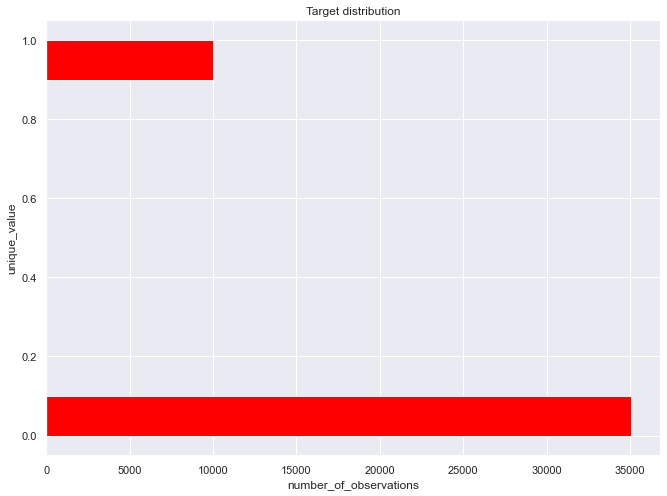

In [8]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

Separate the input variable names by excluding the target:

In [9]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace *NaN* values:

In [10]:
table = fill_nan(data)

Separate the target variable and input features:

In [11]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. 45.68 – 46.17
4. 52.56 – 52.88

In [12]:
#Using functions defined in the materials
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

In [13]:
np.random.seed(0)

avg_age_bootstrap = [np.mean(sample) for sample in 
    get_bootstrap_samples(data[data["SeriousDlqin2yrs"] == 1]["age"].values, 1000)]

q2 = stat_intervals(avg_age_bootstrap, 0.1)

print("Mean interval (confidence 90%)")

for i in q2:
    print(round(i, 2))


Mean interval (confidence 90%)
45.71
46.13


***With a probability of 90% the age of those, who did not repay loan (within 2 years) is between 45.71 and 46.13 years. <br> 
=> The answer is 2.***

## Logistic regression

Let's set up to use logistic regression:

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [15]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [16]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. 0.001
3. 0.01
4. 0.1
5. 1
6. 10

In [18]:
gscv_q3 = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, verbose=1, scoring="roc_auc")
gscv_q3.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc', verbose=1)

In [19]:
gscv_q3.best_params_, gscv_q3.best_score_

({'C': 0.001}, 0.8089120626797153)

***So, for this dataset with ROC AUC scoring method, the best result of accuracy with 80.89% is achieved with C = 0.001 (answer 2).***

Also, it is possible to test and plot individualy each of C-params accoring to the accuracy.

In [20]:
param = [0.0001, 0.001, 0.01, 0.1, 1, 10]
score = []

for i in param:
    l = []
    l.append(i)
    
    parameters = {}
    parameters["C"] = l
        
    gscv_q3_1 = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, verbose=1, scoring="roc_auc")
    gscv_q3_1.fit(X, y)
    score.append(gscv_q3_1.best_score_)
score

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[0.7892508603023743,
 0.8089120626797153,
 0.804895089740052,
 0.7982960783059135,
 0.7952074617556464,
 0.8005215489569266]

(0.0001, 0.01)

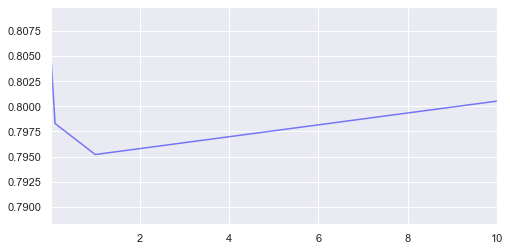

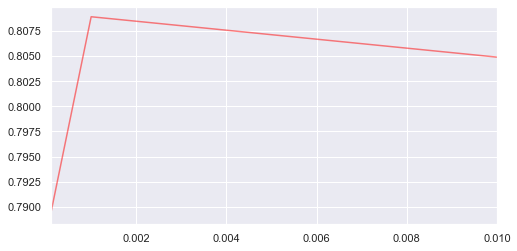

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(param, score, alpha=0.5, color='blue')
ax.set_xlim([0.0001,10])
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(param, score, alpha=0.5, color='red')
ax.set_xlim([0.0001,0.01])

Blue-lined graph shows, that the peak in the zone of small C-param values, so zoom there to see it (red-lined graph). As it could be seen - the peak is achived at point 0.001.

Actually, can be done much easier by using <code> gscv_q3.cv_results_["mean_test_score"] </code>,
plotting against params. The graphs will be the same nevertheless

**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. No

In [22]:
print(gscv_q3.cv_results_.keys())
# So it is a dictionary, and data for all params stored there. Thus graphs above could've beet drawn
# directly by this dict. Added text above regarding it.

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [23]:
# As there is an std keys in it - related to validation, should be 'std_test_score'
print(gscv_q3.cv_results_["std_test_score"])

#Oh, well, the one for the best models should be picked up, can do it by calling .best_index_

[0.00729216 0.00813756 0.00795486 0.00516293 0.00736048 0.00517252]


In [24]:
print(gscv_q3.cv_results_["std_test_score"][gscv_q3.best_index_])

if(gscv_q3.cv_results_["std_test_score"][gscv_q3.best_index_] < 0.005):
    print("Stable")
else:
    print("Not stable")


0.008137559189742445
Not stable


***So, with the standard deviation on validation of 0.814%, the best model is not stable (answer 2).*** 

In [25]:
# The value of accuracy of this model was shown by me in the task 3, 
# so here only save it to variable explicitly
roc_auc_b_val = gscv_q3.best_score_

## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

***As data standardization (or sometimes normalization techniques) I know Z-score, which is done by (Xi -Xmean)/Xstd, for each of the values of the feauture (and to each of the features). Then, by creating (actually fitting) a regression with standardized features - the coefficients of regression will actually show the "importance" of the feature.***

In [26]:
X_normalized = X.copy()

In [27]:
for i in X_normalized.columns:
    mean = X_normalized[i].mean()
    std = X_normalized[i].std()
    
    X_normalized[i] = (X_normalized[i]-mean)/std

Targer variable cannot be normalized, as it is a categorical feature (otherwise logistic regression will not accept the param y).

At first I forgot to put C=0.001 as a parameter for regression, thus obtaining the same ranking (not affecting the answer), but with different weights.

In [28]:
#Fitting all to the regression:
lr_q5 = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr_q5.fit(X_normalized, y);

In [29]:
dict_importance = {}
for i in range(7):
    print(independent_columns_names[i], lr_q5.coef_.flatten().tolist()[i])
    dict_importance[independent_columns_names[i]] = [lr_q5.coef_.flatten().tolist()[i]]

age -0.4167062019838195
NumberOfTime30-59DaysPastDueNotWorse 0.7234231790501988
DebtRatio -0.024096268620647794
NumberOfTimes90DaysLate 0.5167854366890122
NumberOfTime60-89DaysPastDueNotWorse 0.19355697747079134
MonthlyIncome -0.1631469164651595
NumberOfDependents 0.10144428814876912


In [30]:
dict(sorted(dict_importance.items(), key=lambda item: item[1]))

{'age': [-0.4167062019838195],
 'MonthlyIncome': [-0.1631469164651595],
 'DebtRatio': [-0.024096268620647794],
 'NumberOfDependents': [0.10144428814876912],
 'NumberOfTime60-89DaysPastDueNotWorse': [0.19355697747079134],
 'NumberOfTimes90DaysLate': [0.5167854366890122],
 'NumberOfTime30-59DaysPastDueNotWorse': [0.7234231790501988]}

***So, the most important feature is NumberOfTime30-59DaysPastDueNotWorse (answer 2).***

Also, I would like to notice, that the solution uses approach with StandardScaler(), but the achieved result is the very same in terms of ranking (the features are ranked in the same way in my approach), and quite close by the weight, so it may be assumed that StandardScaler() uses Z-score itself.

**Question 6.** Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

1. 0.38
2. -0.02
3. 0.11
4. 0.24

So, softmax function is a function, that that turns values into probabilities that sum to one. In the scope of the task, it is seemed to be applied to beta-coefficients of regression, getting different scaling of the degree of the "importance".

In [31]:
#Softmax can be calculated directly by the scipy
from scipy.special import softmax
softmax(lr_q5.coef_[0])

array([0.07716152, 0.24129743, 0.11426392, 0.19625063, 0.14204787,
       0.09943063, 0.12954799])

In [32]:
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

***So, DebtRatio importance is under index 2, which means it is 0.11 (answer 3). The sum of the resulted "softmaxed" array is 1 indeed.***

In [33]:
softmax(lr_q5.coef_[0]).sum()

0.9999999999999997

**Question 7.** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. 0.70
3. 8.32
4. 0.66

The materials mentioned in "here" are showing the way with $e^{(b_i * change)}$ Age is the $b_1$ or under index 0 in array of $\beta$ coefficients.

In [34]:
lr_q7 = LogisticRegression(C = 0.001, random_state=5, class_weight="balanced")
lr_q7.fit(X, y);

In [35]:
lr_q7.coef_[0]

array([-1.32051709e-02,  4.68115103e-01, -1.01177163e-05,  4.11861030e-01,
        2.37901337e-01, -1.12802750e-05,  1.48505413e-01])

In [36]:
from math import exp
exp(lr_q7.coef_[0][0]*20)

0.7678941217197195

As the result, the chance will increase by 0.77, which is not fitting any of the given answers. The result shown in the solutions is different too, but after running it on the local device - it will give this answer, as I have it above. The difference might be due to changes in the versions of packages and changes in calculations, related to it. ***Thus, the answer for this question is 0.77 and non of the options above (0.70 is the closest one, but still differs, so it cannot be selected as an answer).*** 

## Random Forest

Import the Random Forest classifier:

In [37]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [38]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

We will search for the best parameters among the following values:

In [51]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation?

1. 4%
2. 3%
3. 2%
4. 1%

Everything is given above, all that's left - is just to plug in all parameters and fit regression.

In [56]:
gscv_q8 = GridSearchCV(rf, parameters, n_jobs=-1, scoring="roc_auc" , cv=skf, verbose=True)
gscv_q8 = gscv_q8.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [61]:
print("Random forest ROC AUC estimation: ", gscv_q8.best_score_)
print("Logistic regression ROC AUC estimation: ", roc_auc_b_val)
print("Difference is: ", (gscv_q8.best_score_ - roc_auc_b_val)*100)

Random forest ROC AUC estimation:  0.8357327333345677
Logistic regression ROC AUC estimation:  0.8089120626797153
Difference is:  2.6820670654852385


***So, it is 2.68%, which is rounded to 3% - answer 2. It is different from the results in the solution - there was 4% due to the same reasons described above (the answer provided in solutions is not reproducible on the local machine).***

**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [87]:
dict_importance_q9 = {}
for i in range(7):
    print(independent_columns_names[i], gscv_q8.best_estimator_.feature_importances_[i])
    dict_importance_q9[independent_columns_names[i]] = gscv_q8.best_estimator_.feature_importances_[i]
importances = dict(sorted(dict_importance_q9.items(), key=lambda item: item[1]))
importances

age 0.1155872837894519
NumberOfTime30-59DaysPastDueNotWorse 0.3010109770272061
DebtRatio 0.07611829713786611
NumberOfTimes90DaysLate 0.2784466485785146
NumberOfTime60-89DaysPastDueNotWorse 0.1562167026439687
MonthlyIncome 0.05827660527611587
NumberOfDependents 0.014343485546876722


{'NumberOfDependents': 0.014343485546876722,
 'MonthlyIncome': 0.05827660527611587,
 'DebtRatio': 0.07611829713786611,
 'age': 0.1155872837894519,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.1562167026439687,
 'NumberOfTimes90DaysLate': 0.2784466485785146,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.3010109770272061}

In [84]:
dict_importance_q9

{'age': 0.1155872837894519,
 'NumberOfTime30-59DaysPastDueNotWorse': 0.3010109770272061,
 'DebtRatio': 0.07611829713786611,
 'NumberOfTimes90DaysLate': 0.2784466485785146,
 'NumberOfTime60-89DaysPastDueNotWorse': 0.1562167026439687,
 'MonthlyIncome': 0.05827660527611587,
 'NumberOfDependents': 0.014343485546876722}

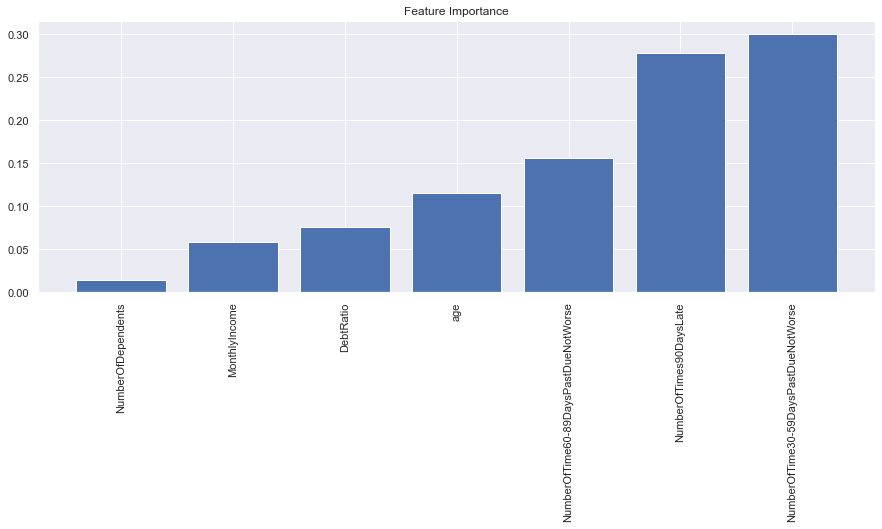

In [90]:
# Also can do a barplot of the importances, starting with the lowest.
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
plt.bar(range(len(importances)), list(importances.values()), align='center')
plt.xticks(range(len(importances)), list(importances.keys()), rotation=90);

***Based on results - NumberOfDependents is the least impactful feature out of the all set of the features (the answer is 7).***

**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. Feature interpretability;
4. Linear properties of the algorithm.

The time is not of the essence here, so definitely not the 1st.
Highly doubt about the 2nd too.

3rd actually seems fine, as in the materials were mentioned pros and cons of Random Forest and there were such 2 cons:
- In comparison with a single decision tree, Random Forest's output is more difficult to interpret.
- There are no formal p-values for feature significance estimation.

So, this definitely tells that in general, the Random Forest is hard to interpret in feature-wise approach.

4th seems not to be applicable here, as yes, it is performing worse compared to linear models, but only in case of sparse data (which is text inputs, bag of words, etc.). Thus not applicable to the problem with numerical data.

***So, only 3rd answer seems to be correct => Feature interpretability.***

## Bagging

Import modules and set up the parameters for bagging:

In [91]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. 80.75%
2. 80.12%
3. 79.62%
4. 76.50%

In [95]:
RandomizedSearchCV?
BaggingClassifier?

In [96]:
rscv_q11 = RandomizedSearchCV(
    BaggingClassifier(LogisticRegression(class_weight="balanced"), 
                      n_estimators=100, random_state=42, n_jobs=-1),
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True,
)

In [97]:
rscv_q11 = rscv_q11.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [98]:
rscv_q11.best_score_

0.8087951623513827

All parameters were set according the task and the best ROC AUC is 80.88%, which is not equal to any of the given choices. Solution shows, that the correct answer is 80.76%, which is not reproducible on the local machine. ***Thus, the answer for this question is 80.88%, which is out of the list of answers.***

**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. Less correlation between single models;
4. The higher the number of features, the lower the loss of information.

In [99]:
rscv_q11.best_params_

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}

It should be similar to Random Forest approach and somehow similar to multicollinearity problem (when high correlation between features (aka predictors) and the fact that some of the features are a linear combination of the other(s) lead to less accurate and "danger" models for its possible misleading interpretation, bigger confidence interval, poorly defined significance, etc.). So, to maintain good quality of the results and avoid such problems - it is tuned such way, that there is less correlation between single models (similarly to feature correlation). ***So, the answer is 3.*** But, I guess, in the materials it was mention, that yes, Bagging works better on small samples, but it is in general, not related to the params tuning. 